In [1]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl
import cv2
import json
from ipywidgets import interact
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from mmdet import core
import torch
import warnings
warnings.filterwarnings('ignore')

/home/user304/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
def js_to_img(data_path):
    data_path = data_path.replace('labels' , 'defect').replace('json' , 'jpg')
    return data_path

def dict_value_to_int(anno):
    anno = {k: int(v) for k , v in anno.items()}
    x ,y , w, h = anno['x'] , anno['y'] , anno['width'] , anno['height']
    x1 , y1 = x - (w // 2) , y - (h //2)
    x2 , y2 =  x + (w // 2) , y + (h //2)

    return x1 ,y1 , x2 , y2


def yolo_to_cv2_format(anno):
    x_c ,y_c , w, h = anno
    x1 , y1 = x_c - (w // 2) , y_c - (h //2)
    x2 , y2 =  x_c + (w // 2) , y_c + (h //2)

    return x1 ,y1 , x2 , y2

def get_anchor(anchor_i):
    w = anchor_i[:, 2] - anchor_i[:, 0]
    h = anchor_i[:, 3] - anchor_i[:, 1]
    return torch.stack([w,h] , dim = 1 ).cpu().numpy()

    
# coco format으로 부터 img load 하는 방식
def coco_img(idx):
    global coco
    img = cv2.imread('../dataset/' + coco.loadImgs(idx)[0]['file_name'])
    annIds = coco.getAnnIds(imgIds=idx, iscrowd=None)
    anns = coco.loadAnns(annIds)
    for obj in anns:
        anno = obj['bbox']
        label_str = coco.loadCats(obj['category_id'])[0]['name']
        anno = yolo_to_cv2_format(anno)        
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, label_str, (anno[0], anno[1] -5), font, 0.8, (0, 255, 0), 2)
        img = cv2.rectangle(img , (anno[0] , anno[1]) , ( anno[2]  , anno[3]), color = (0,255, 0) , thickness = 1)
    plt.figure(figsize = (15,15))
    plt.imshow(img)
    plt.show()

def get_centroids(coco ,n_clusters , savefig = True):
    id_to_cat = {x['id'] : x['name'] for x in coco.loadCats(coco.getCatIds())}
    bbox_by_cat= [[data['bbox'][2] , data['bbox'][3] ,data['bbox'][2] * data['bbox'][3] , id_to_cat[data['category_id']] ] for data in coco.loadAnns(coco.getAnnIds())]
    df = pd.DataFrame(bbox_by_cat , columns = [ 'width' , 'height','area' , 'category'])

    kmeans_bbox = KMeans(n_clusters= n_clusters , random_state=42)
    kmeans_bbox.fit( df[['width' , 'height']])
    centroids_bbox = kmeans_bbox.cluster_centers_

    kmeans_area = KMeans(n_clusters= n_clusters , random_state=42)
    kmeans_area.fit( df['area'].values.reshape(-1, 1))
    centroids_area = kmeans_area.cluster_centers_

    fig , ax = plt.subplots(1 , 2, figsize = (16,5 ))

    sns.scatterplot(x = 'width' , y = 'height' , hue = 'category' ,data = df  , ax = ax[0]  )
    ax[0].scatter(centroids_bbox[:,0] , centroids_bbox[:,1]  , marker = 'v'  , c ='blue'  , edgecolors= 'black' ,  s = 50 )
    ax[0].set_title('Bounding box')

    sns.histplot( df['area'] , bins = 100)
    ax[1].axvline(x = centroids_area.sum() / len(centroids_area) , color = 'red')
    ax[1].set_title('Area')

    # if savefig:
    #     plt.savefig('result/centroids.png' , dpi = 300)
    print()
    print(f"area max min : ({df['area'].min()} , {df['area'].max()} )")
    return centroids_bbox , centroids_area , df , fig , ax


In [3]:
coco = COCO('../dataset/coco.json')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!



area max min : (864 , 28258 )


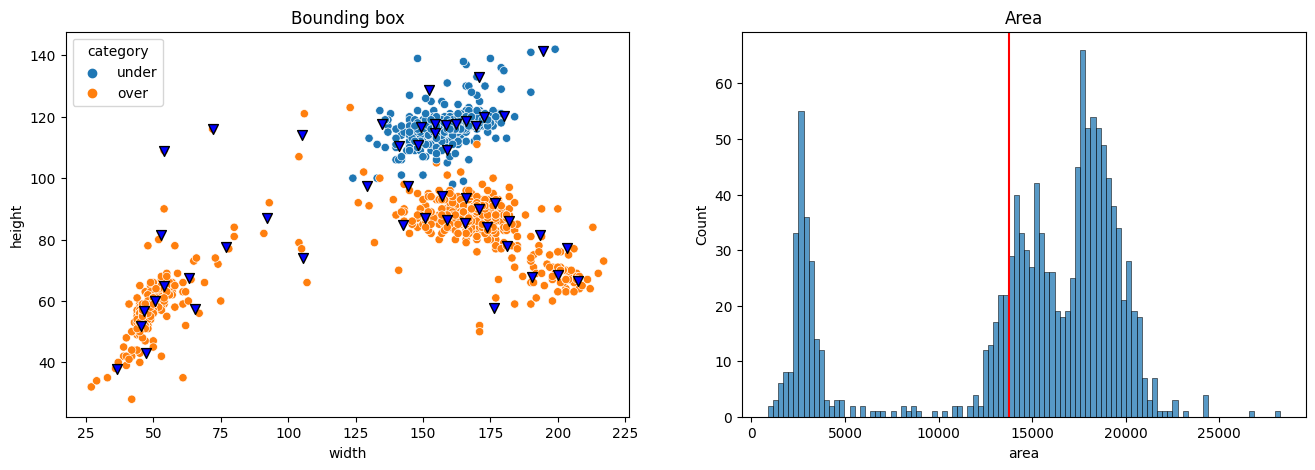

In [4]:
centroids_bbox , centroids_area , df , fig  , ax = get_centroids(coco ,50 , savefig=False)


area max min : (864 , 28258 )


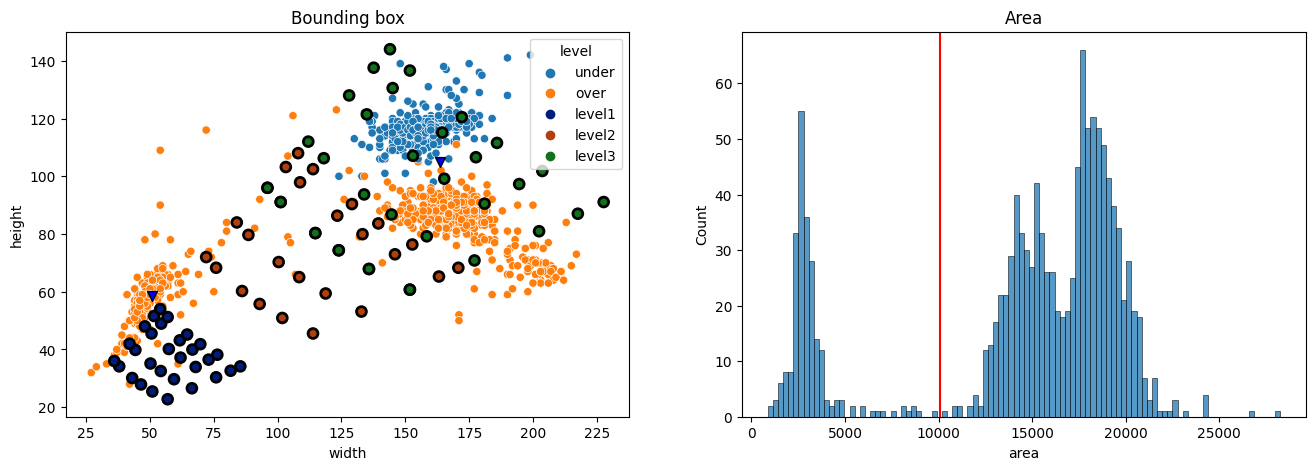

In [14]:
generator = core.AnchorGenerator(            
            scales = [3, 3.5, 4,4.3 ,4.5] , 
            ratios=[ 0.4,  0.5,0.6, 0.7,0.9,1.0 ],
            strides=[12, 24, 32])
anchor = generator.grid_anchors([(1,1) , (1,1) , (1,1) ])



anchor_w_h = { f'level{i+1}' : get_anchor(anchor_i) for i, anchor_i in enumerate(anchor)}
df_s = pd.DataFrame(columns = ['x','y','level'])
for level in anchor_w_h.keys():
    df_s_i = pd.DataFrame({
        "x": anchor_w_h[level][:,0].reshape(-1).tolist(),
        "y": anchor_w_h[level][:,1].reshape(-1).tolist(),
        'level' : level} )
    df_s = pd.concat([df_s , df_s_i] ,axis = 0)

centroids_bbox , centroids_area , df , fig  , ax = get_centroids(coco , 2)
sns.scatterplot(df_s['x'] , df_s['y'] , hue = df_s['level'], s = 50   , ax=ax[0] , palette ='dark' , edgecolor="black" ,linewidth = 2 )
plt.show()

In [61]:
df

,width,height,area,category
0,186,65,12090,over
1,134,89,11926,under
2,84,71,5964,over
3,167,60,10020,over
4,175,62,10850,over
...,...,...,...,...
419,191,68,12988,over
420,43,59,2537,over
421,200,79,15800,over
422,37,54,1998,over


,x,y,level
0,65.7267,19.718014,level1
1,76.681152,23.004349,level1
2,87.635605,26.290684,level1
3,98.590057,29.577019,level1
4,56.921001,22.768398,level1
...,...,...,...
19,135.0,135.0,level3
20,82.158386,98.590057,level3
21,95.851448,115.021736,level3
22,109.54451,131.453415,level3


In [45]:
anchor_w_h['level1'][:,0].reshape(-1)

[65.72669982910156,
 76.68115234375,
 87.63560485839844,
 98.59005737304688,
 56.92100143432617,
 66.4078369140625,
 75.89466857910156,
 85.38150024414062,
 46.475799560546875,
 54.221763610839844,
 61.96773147583008,
 69.71369934082031,
 43.028228759765625,
 50.19960021972656,
 57.3709716796875,
 64.54234313964844,
 36.0,
 42.0,
 48.0,
 54.0,
 32.86334991455078,
 38.340576171875,
 43.81780242919922,
 49.29502868652344]